---
title: "Characterization of PanUKB hidden factors"
author: "Saikat Banerjee"
format:
  html: default
date: "2024-03-07"
file-modified: "2024-03-07"
abstract: "We attempt to characterize the latent structure of the PanUKB summary statistics using our methods."

---

In [2]:
import os
import re
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from adjustText import adjust_text
import textalloc

from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')
from matplotlib.gridspec import GridSpec

import sys
sys.path.append("../utils/")
import simulate as mpy_simulate

In [12]:
import scipy.stats as sc_stats
import collections

def q1(x, axis = None):
    return np.percentile(x, 25, axis = axis)

def q3(x, axis = None):
    return np.percentile(x, 75, axis = axis)

def iqr_outlier(x, axis = None, bar = 1.5, side = 'both'):
    assert side in ['gt', 'lt', 'both'], 'Side should be `gt`, `lt` or `both`.'

    d_iqr = sc_stats.iqr(x, axis = axis)
    d_q1 = q1(x, axis = axis)
    d_q3 = q3(x, axis = axis)
    iqr_distance = np.multiply(d_iqr, bar)

    stat_shape = list(x.shape)

    if isinstance(axis, collections.abc.Iterable):
        for single_axis in axis:
            stat_shape[single_axis] = 1
    else:
        stat_shape[axis] = 1

    if side in ['gt', 'both']:
        upper_range = d_q3 + iqr_distance
        upper_outlier = np.greater(x - upper_range.reshape(stat_shape), 0)
    if side in ['lt', 'both']:
        lower_range = d_q1 - iqr_distance
        lower_outlier = np.less(x - lower_range.reshape(stat_shape), 0)

    if side == 'gt':
        return upper_outlier
    if side == 'lt':
        return lower_outlier
    if side == 'both':
        return np.logical_or(upper_outlier, lower_outlier)

# Read data and results

In [3]:
data_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/data"
result_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/nnsparsh"
h2_cut = 0.1
pval_cut = 5e-8

zscore_df = pd.read_pickle(os.path.join(data_dir, f"modselect/zscore_h2{h2_cut}_pval{pval_cut}.pkl"))
trait_df  = pd.read_pickle(os.path.join(data_dir, f"modselect/traits_h2{h2_cut}.pkl"))

variant_filename = f"{data_dir}/allvar.pruned.closesttss.hugo"
variant_df = pd.read_csv(variant_filename, sep = '\t')

In [4]:
zscore_df

,z1415,z1678,z1679,z1680,z1681,z1682,z1683,z1685,z1686,z1687,...,z2473,z2474,z2475,z2476,z2477,z2479,z2480,z2481,z2482,z2483
0,3.591973,-0.038545,4.356103,-0.030974,-2.625193,-0.082182,-1.513514,2.927977,1.145769,-0.924589,...,-0.964337,1.521092,0.612532,1.405428,0.018029,-0.008761,-2.069432,-4.292948,-4.701711,2.952899
1,2.690253,2.060959,5.074098,2.131896,-2.200532,0.203585,0.053289,2.081926,1.606040,-0.265317,...,-0.158982,-0.296537,-0.734266,-0.093081,0.412077,0.716049,-2.171984,-5.314085,-6.612137,3.817518
2,4.672697,1.966395,6.363325,1.017074,-3.506709,-0.985765,-0.432902,2.834796,3.055340,-2.151471,...,0.716255,2.222433,1.092969,2.328233,1.160767,-1.467249,-0.135785,-2.187241,-3.223529,4.508578
3,3.628734,0.377612,1.851399,-1.249221,-1.881565,-0.479096,-1.015920,0.498607,-0.294269,-1.046150,...,-1.404276,3.356354,1.990588,3.092179,-0.133810,-1.376310,1.317044,0.913491,0.535188,2.245657
4,-0.858911,-0.623239,-1.686601,-3.003435,0.532031,-0.341693,-3.777505,0.254496,0.226082,-0.322407,...,-0.536635,-0.320075,-0.128047,-0.524757,-0.232900,-0.483644,2.026508,4.400092,5.407316,1.125536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51394,1.342127,1.797208,-0.979370,-1.867291,0.037906,-1.162637,-3.256483,2.176569,-1.732998,-0.328859,...,0.482023,0.714167,0.354347,0.611158,-0.354725,-0.831737,0.870924,1.432076,2.228501,0.536104
51395,-1.244520,-1.527636,1.849772,2.144946,-0.031816,2.274951,2.456148,-2.560491,-0.212461,0.982478,...,-0.110369,1.107098,1.482684,1.512723,0.322355,1.320194,-0.700092,-1.395039,-2.270186,0.360025
51396,-0.253862,0.812630,-0.711050,1.179577,-2.862653,-2.013295,2.833169,0.153290,2.138158,-2.653582,...,-0.088946,-0.562063,-1.148515,-0.994185,-0.268232,0.013256,-0.777667,-1.544760,-1.406344,2.205817
51397,-0.915597,1.668377,-0.823597,0.163447,-0.061726,0.319698,0.922030,2.559199,0.215736,0.468609,...,0.098326,-1.185702,-0.624073,-0.859522,0.549669,0.268733,0.947441,1.533302,1.658537,2.218653


In [5]:
trait_df

,zindex,trait_type,phenocode,pheno_sex,description,description_more,category,BIN_QT,n_cases_EUR,n_controls_EUR,N,Neff,estimates.final.h2_observed
1414,1415,categorical,20002,both_sexes,"Non-cancer illness code, self-reported",Code for non-cancer illness. If the participan...,UK Biobank Assessment Centre > Verbal intervie...,BIN,109307,311166.0,420473,161782.6684,0.125
1677,1678,biomarkers,30600,both_sexes,Albumin,NaN,Biological samples > Assay results > Blood ass...,QT,367192,NaN,367192,367192.0000,0.145
1678,1679,biomarkers,30610,both_sexes,Alkaline phosphatase,NaN,Biological samples > Assay results > Blood ass...,QT,400988,NaN,400988,400988.0000,0.205
1679,1680,biomarkers,30620,both_sexes,Alanine aminotransferase,NaN,Biological samples > Assay results > Blood ass...,QT,400822,NaN,400822,400822.0000,0.124
1680,1681,biomarkers,30630,both_sexes,Apolipoprotein A,NaN,Biological samples > Assay results > Blood ass...,QT,364987,NaN,364987,364987.0000,0.182
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2478,2479,continuous,Smoking,both_sexes,"Smoking status, ever vs never",Ever (previous + current smoker) vs never base...,NaN,QT,418817,NaN,418817,418817.0000,0.110
2479,2480,continuous,eGFR,both_sexes,"Estimated glomerular filtration rate, serum cr...",eGFR based on serum creatinine (30700) using t...,NaN,QT,401867,NaN,401867,401867.0000,0.207
2480,2481,continuous,eGFRcreacys,both_sexes,"Estimated glomerular filtration rate, cystain C",eGFR based on cystain C (30720) using the CKD-...,NaN,QT,401570,NaN,401570,401570.0000,0.238
2481,2482,continuous,eGFRcys,both_sexes,"Estimated glomerular filtration rate, serum cr...",eGFR based on serum creatinine (30700) and cys...,NaN,QT,402031,NaN,402031,402031.0000,0.224


In [6]:
method_names = {
    'rpca' : 'RPCA-IALM',
    'nnm'  : 'NNM-FW',
    'nnm_sparse' : 'NNM-Sparse-FW',
}

In [7]:
lowrank_model = dict()
for m in method_names.keys():
    res_filename = os.path.join(result_dir, f"{m}_model.pkl")
    with (open(res_filename, "rb")) as fh:
        lowrank_model[m] = pickle.load(fh)

In [8]:
lowrank_X = dict()
for m in method_names.keys():
    if m == 'rpca':
        lowrank_X[m] = lowrank_model[m]['L_']
    else:
        lowrank_X[m] = lowrank_model[m]['X_']

In [9]:
def get_principal_components(X):
    X_cent = mpy_simulate.do_standardize(X, scale = False)
    X_cent /= np.sqrt(np.prod(X_cent.shape))
    U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    pcomps = U @ np.diag(S)
    loadings = Vt.T @ np.diag(S)
    return loadings, pcomps, S

loadings  = dict()
pcomps    = dict()
eigenvals = dict()

for m in method_names.keys():
    loadings[m], pcomps[m], eigenvals[m] = get_principal_components(lowrank_X[m])

In [10]:
trait_types  = trait_df['trait_type'].unique().tolist()
trait_colors = {trait: color for trait, color in zip(trait_types, mpl_stylesheet.banskt_colors()[:len(trait_types)])}
trait_types.reverse()

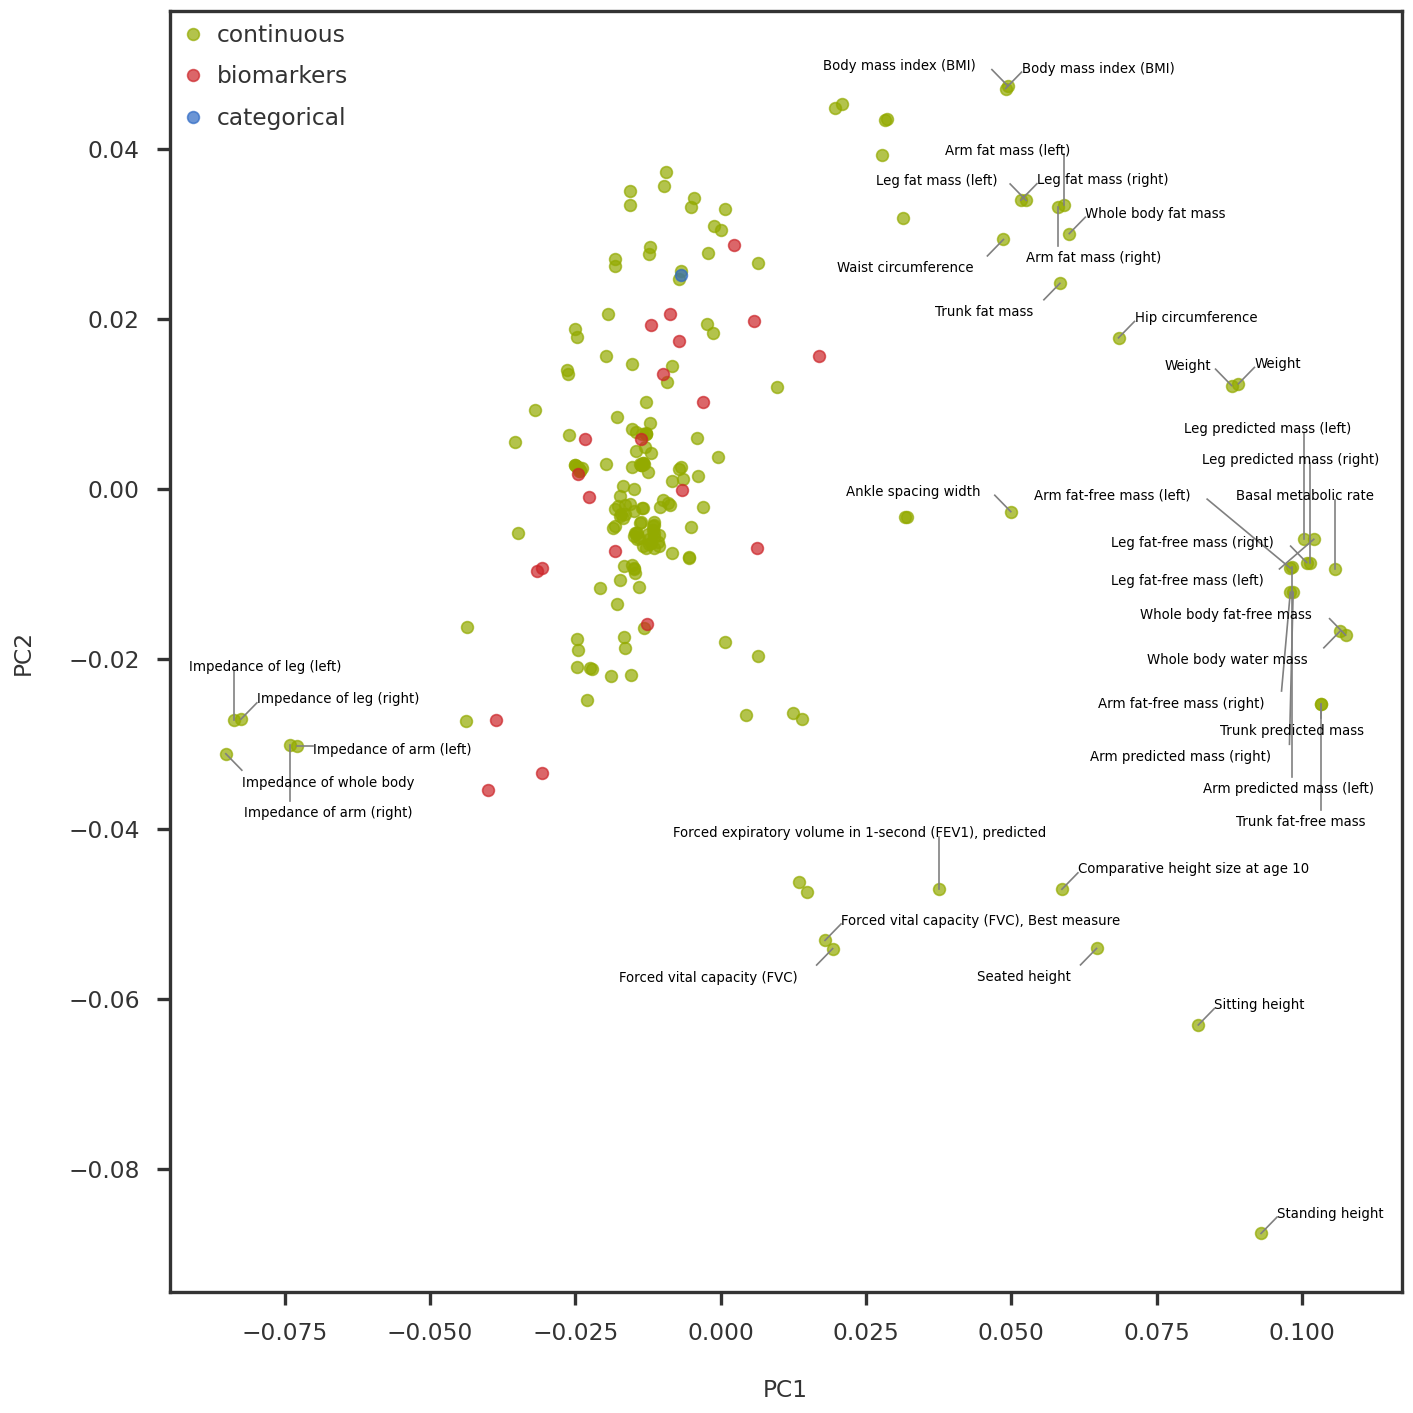

In [22]:
fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(111)
method = 'nnm_sparse'
ipc1 = 0
ipc2 = 1
trait_indices = np.array(trait_df.index)

for t in trait_types:
    selectidx = np.array(trait_df[trait_df['trait_type'] == t].index)
    tidx = np.searchsorted(trait_indices, selectidx)
    xvals = pcomps[method][tidx, ipc1]
    yvals = pcomps[method][tidx, ipc2]
    ax1.scatter(xvals, yvals, alpha = 0.7, color = trait_colors[t], label = t, s = 50)
    ax1.legend(loc = 'upper left')
    

# Combine outliers in x-axis and y-axis
xvals = pcomps[method][:, ipc1]
yvals = pcomps[method][:, ipc2]
outlier_idx_x = np.where(iqr_outlier(xvals, axis = 0, bar = 2.0))[0]
outlier_idx_y = np.where(iqr_outlier(yvals, axis = 0, bar = 2.0))[0]
outlier_idx = np.union1d(outlier_idx_x, outlier_idx_y)
x_center = np.mean(ax1.get_xlim())

# # Mark using adjustText package
# # https://github.com/Phlya/adjustText
# annots = []
# for i in outlier_idx:
#     txt = trait_df.loc[trait_indices[i]]['description'].strip()
#     if 'intima-medial thickness' in txt:
#         continue
#     if xvals[i] > x_center:
#         annots += [ax1.annotate(txt, (xvals[i], yvals[i]), fontsize = 6, ha = 'right')]
#     else:
#         annots += [ax1.annotate(txt, (xvals[i], yvals[i]), fontsize = 6)]
# # Adjust the annotations iteratively
# adjust_text(annots, arrowprops=dict(arrowstyle='-', color = 'grey'))

# Mark using textalloc package
txt_list = []
text_idx_list = []
for i in outlier_idx:
    txt = trait_df.loc[trait_indices[i]]['description'].strip()
    #if 'intima-medial thickness' in txt:
    #    continue
    txt_list.append(txt)
    text_idx_list.append(i)
if len(text_idx_list) > 0:
    txt_idx = np.array(text_idx_list)
    textalloc.allocate_text(fig, ax1, xvals[txt_idx], yvals[txt_idx], txt_list,
                            x_scatter = xvals, y_scatter = yvals,
                            textsize = 8, textcolor = 'black', linecolor = 'grey')

ax1.set_xlabel(f"PC{ipc1 + 1}")
ax1.set_ylabel(f"PC{ipc2 + 1}")
    
plt.tight_layout()
plt.show()

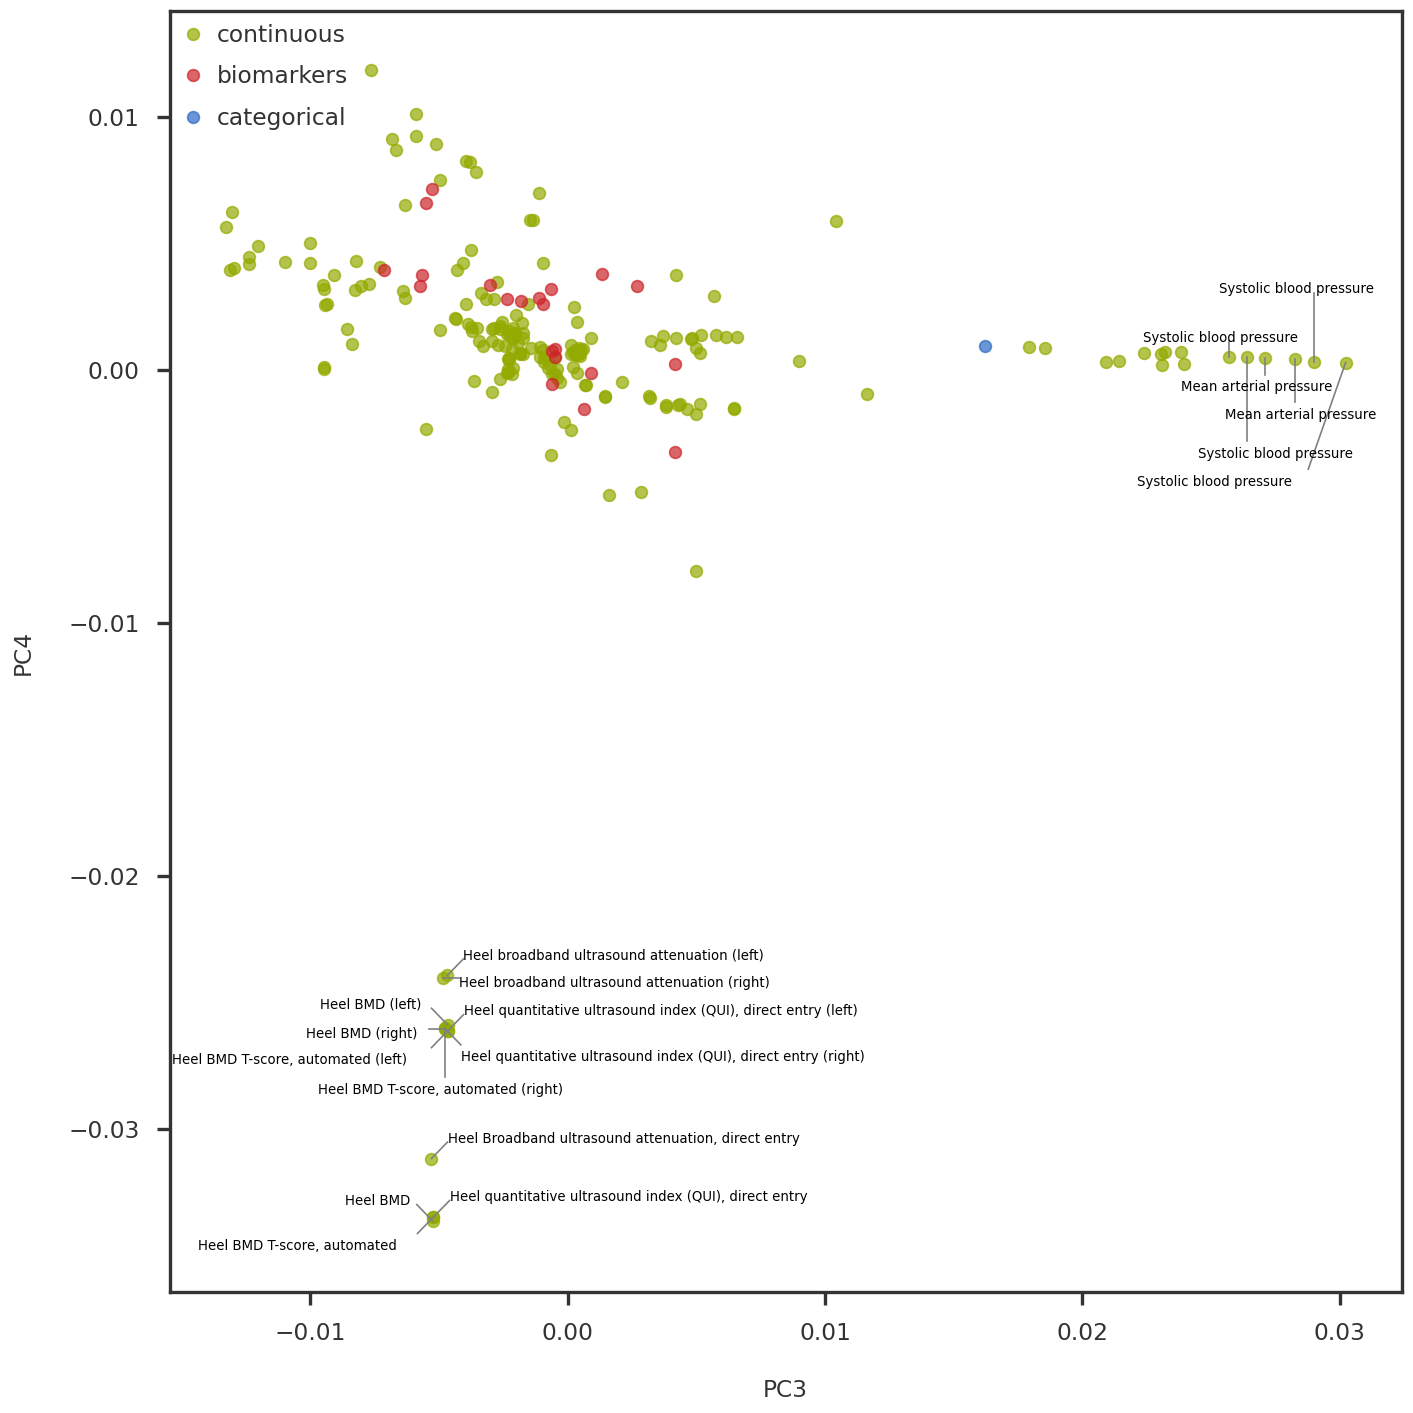

In [23]:
fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(111)
method = 'nnm_sparse'
ipc1 = 2
ipc2 = 3
trait_indices = np.array(trait_df.index)

for t in trait_types:
    selectidx = np.array(trait_df[trait_df['trait_type'] == t].index)
    tidx = np.searchsorted(trait_indices, selectidx)
    xvals = pcomps[method][tidx, ipc1]
    yvals = pcomps[method][tidx, ipc2]
    ax1.scatter(xvals, yvals, alpha = 0.7, color = trait_colors[t], label = t, s = 50)
    ax1.legend(loc = 'upper left')
    

# Combine outliers in x-axis and y-axis
xvals = pcomps[method][:, ipc1]
yvals = pcomps[method][:, ipc2]
outlier_idx_x = np.where(iqr_outlier(xvals, axis = 0, bar = 4.0))[0]
outlier_idx_y = np.where(iqr_outlier(yvals, axis = 0, bar = 4.0))[0]
outlier_idx = np.union1d(outlier_idx_x, outlier_idx_y)
x_center = np.mean(ax1.get_xlim())

# Mark using adjustText package
# https://github.com/Phlya/adjustText
# annots = []
# for i in outlier_idx:
#     txt = trait_df.loc[trait_indices[i]]['description']
#     if 'intima-medial thickness' in txt:
#         continue
#     if xvals[i] > x_center:
#         annots += [ax1.annotate(txt, (xvals[i], yvals[i]), fontsize = 10, ha = 'right')]
#     else:
#         annots += [ax1.annotate(txt, (xvals[i], yvals[i]), fontsize = 10)]
# # Adjust the annotations iteratively
# adjust_text(annots, arrowprops=dict(arrowstyle='-', color = 'grey'))

# Mark using textalloc package
txt_list = []
text_idx_list = []
for i in outlier_idx:
    txt = trait_df.loc[trait_indices[i]]['description'].strip()
    if 'pressure' in txt:
        txt = re.sub(
            pattern=r'(.*pressure),.*', 
            repl='\\1', 
            string = txt)
    #    continue
    if 'bone mineral density' in txt:
        txt = re.sub(
            pattern = r'bone mineral density \(BMD\)',
            repl = 'BMD',
            string = txt)
    txt_list.append(txt)
    text_idx_list.append(i)
if len(text_idx_list) > 0:
    txt_idx = np.array(text_idx_list)
    textalloc.allocate_text(fig, ax1, xvals[txt_idx], yvals[txt_idx], txt_list,
                            x_scatter = xvals, y_scatter = yvals,
                            textsize = 8, textcolor = 'black', linecolor = 'grey')

ax1.set_xlabel(f"PC{ipc1 + 1}")
ax1.set_ylabel(f"PC{ipc2 + 1}")
    
plt.tight_layout()
plt.show()

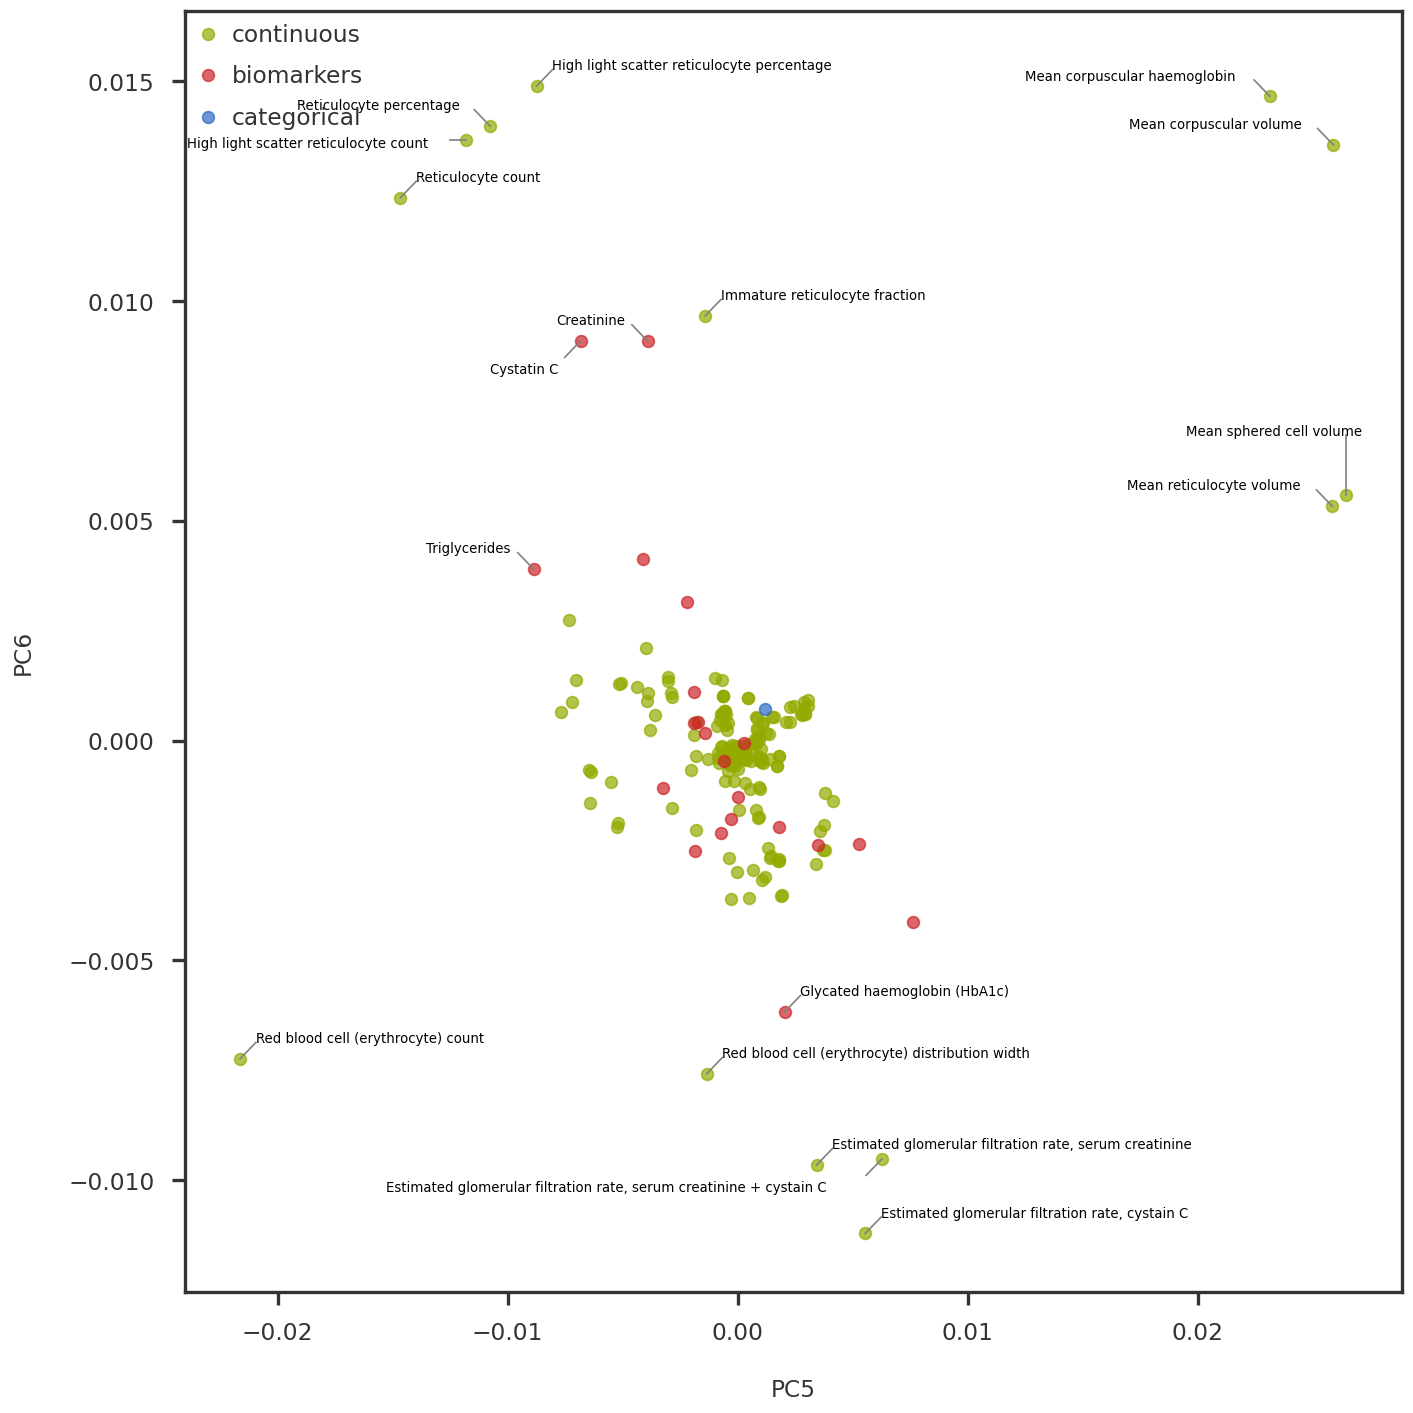

In [24]:
fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(111)
method = 'nnm_sparse'
ipc1 = 4
ipc2 = 5
trait_indices = np.array(trait_df.index)

for t in trait_types:
    selectidx = np.array(trait_df[trait_df['trait_type'] == t].index)
    tidx = np.searchsorted(trait_indices, selectidx)
    xvals = pcomps[method][tidx, ipc1]
    yvals = pcomps[method][tidx, ipc2]
    ax1.scatter(xvals, yvals, alpha = 0.7, color = trait_colors[t], label = t, s = 50)
    ax1.legend(loc = 'upper left')
    

# Combine outliers in x-axis and y-axis
xvals = pcomps[method][:, ipc1]
yvals = pcomps[method][:, ipc2]
outlier_idx_x = np.where(iqr_outlier(xvals, axis = 0, bar = 4.0))[0]
outlier_idx_y = np.where(iqr_outlier(yvals, axis = 0, bar = 4.0))[0]
outlier_idx = np.union1d(outlier_idx_x, outlier_idx_y)
x_center = np.mean(ax1.get_xlim())

# Mark using adjustText package
# https://github.com/Phlya/adjustText
# annots = []
# for i in outlier_idx:
#     txt = trait_df.loc[trait_indices[i]]['description']
#     if 'intima-medial thickness' in txt:
#         continue
#     if xvals[i] > x_center:
#         annots += [ax1.annotate(txt, (xvals[i], yvals[i]), fontsize = 10, ha = 'right')]
#     else:
#         annots += [ax1.annotate(txt, (xvals[i], yvals[i]), fontsize = 10)]
# # Adjust the annotations iteratively
# adjust_text(annots, arrowprops=dict(arrowstyle='-', color = 'grey'))

# Mark using textalloc package
txt_list = []
text_idx_list = []
for i in outlier_idx:
    txt = trait_df.loc[trait_indices[i]]['description'].strip()
    #if 'intima-medial thickness' in txt:
    #    continue
    txt_list.append(txt)
    text_idx_list.append(i)
if len(text_idx_list) > 0:
    txt_idx = np.array(text_idx_list)
    textalloc.allocate_text(fig, ax1, xvals[txt_idx], yvals[txt_idx], txt_list,
                            x_scatter = xvals, y_scatter = yvals,
                            textsize=8, textcolor = 'black', linecolor = 'grey')

ax1.set_xlabel(f"PC{ipc1 + 1}")
ax1.set_ylabel(f"PC{ipc2 + 1}")
    
plt.tight_layout()
plt.show()

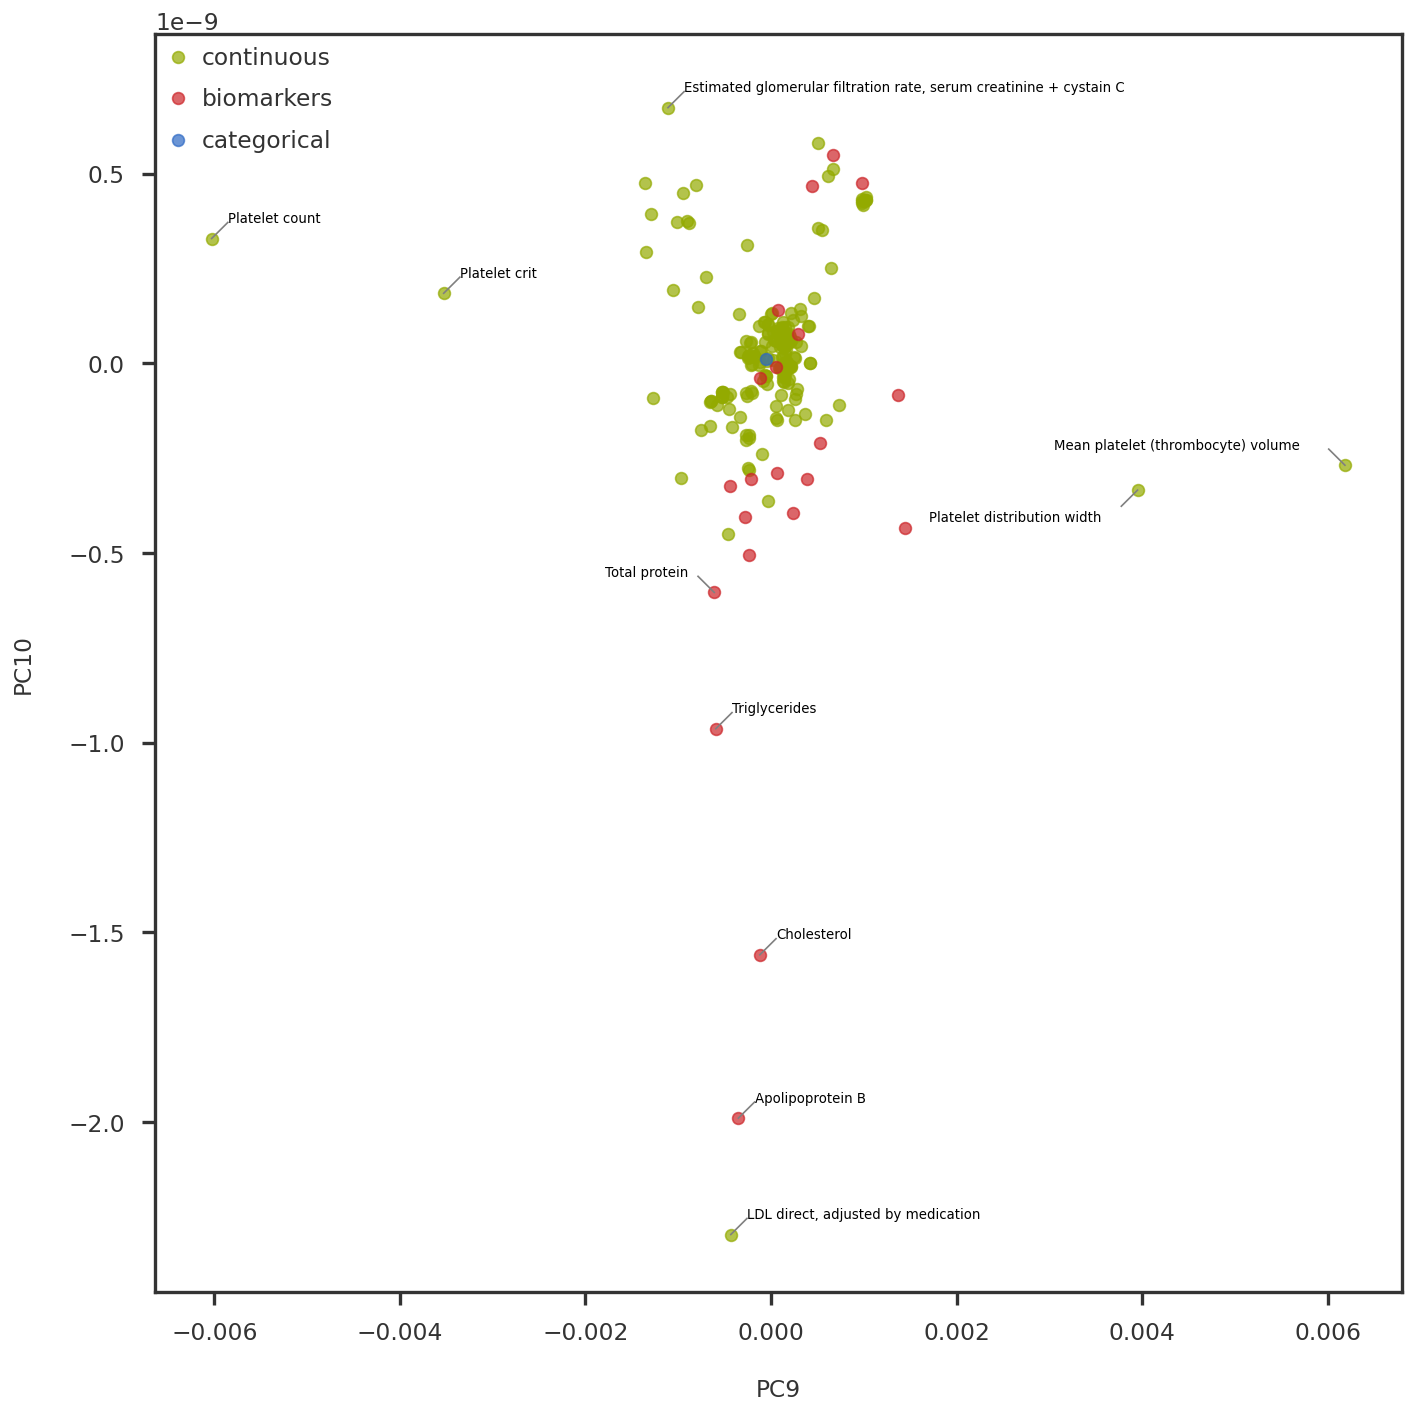

In [31]:
fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(111)
method = 'nnm_sparse'
ipc1 = 8
ipc2 = 9
trait_indices = np.array(trait_df.index)

for t in trait_types:
    selectidx = np.array(trait_df[trait_df['trait_type'] == t].index)
    tidx = np.searchsorted(trait_indices, selectidx)
    xvals = pcomps[method][tidx, ipc1]
    yvals = pcomps[method][tidx, ipc2]
    ax1.scatter(xvals, yvals, alpha = 0.7, color = trait_colors[t], label = t, s = 50)
    ax1.legend(loc = 'upper left')
    

# Combine outliers in x-axis and y-axis
xvals = pcomps[method][:, ipc1]
yvals = pcomps[method][:, ipc2]
outlier_idx_x = np.where(iqr_outlier(xvals, axis = 0, bar = 3.0))[0]
outlier_idx_y = np.where(iqr_outlier(yvals, axis = 0, bar = 3.0))[0]
outlier_idx = np.union1d(outlier_idx_x, outlier_idx_y)
x_center = np.mean(ax1.get_xlim())

# Mark using adjustText package
# https://github.com/Phlya/adjustText
# annots = []
# for i in outlier_idx:
#     txt = trait_df.loc[trait_indices[i]]['description']
#     if 'intima-medial thickness' in txt:
#         continue
#     if xvals[i] > x_center:
#         annots += [ax1.annotate(txt, (xvals[i], yvals[i]), fontsize = 10, ha = 'right')]
#     else:
#         annots += [ax1.annotate(txt, (xvals[i], yvals[i]), fontsize = 10)]
# # Adjust the annotations iteratively
# adjust_text(annots, arrowprops=dict(arrowstyle='-', color = 'grey'))

# Mark using textalloc package
txt_list = []
text_idx_list = []
for i in outlier_idx:
    txt = trait_df.loc[trait_indices[i]]['description'].strip()
    #if 'intima-medial thickness' in txt:
    #    continue
    txt_list.append(txt)
    text_idx_list.append(i)
if len(text_idx_list) > 0:
    txt_idx = np.array(text_idx_list)
    textalloc.allocate_text(fig, ax1, xvals[txt_idx], yvals[txt_idx], txt_list,
                            x_scatter = xvals, y_scatter = yvals,
                            textsize=8, textcolor = 'black', linecolor = 'grey')

ax1.set_xlabel(f"PC{ipc1 + 1}")
ax1.set_ylabel(f"PC{ipc2 + 1}")
    
plt.tight_layout()
plt.show()